<a href="https://colab.research.google.com/github/DariusStaugas/rag-from-scratch-colab/blob/main/RAG_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Library, drive and hugginface setup

In [1]:
#Log into huggingface
!huggingface-cli login

#Mount Google drive. I store all related files there
from google.colab import drive
drive.mount('/content/drive')

#Libraries
!pip install -U PyMuPDF
!pip install -U spacy
!pip install -U scikit-learn
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U sentence-transformers
!pip install -U transformers==4.38.2
!pip install -U bitsandbytes
!pip install -U accelerate



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).

##Declare Global variables and do imports

In [1]:
#Global variables

#Assumes you have created a folder called RAG_project in your Google drive root directory

SMALL_VRAM = True #For gemma-7b anything bellow 18-20GB is too small.
                  #This should be set to True if that is the case
LOW_CPU_MEM_USAGE = True #Makes loading a bit slower, but possible in low RAM (not VRAM)
                        # environments. Does nothing when using CPU to load the LLM model

#Change these deppending on setup
PROJECT_LOCATION = '/content/drive/MyDrive/RAG_project'
PDF_LOCATION = PROJECT_LOCATION + '/human-nutrition-text.pdf'
EMBEDDINGS_DF_SAVE_PATH = '/content/drive/MyDrive/RAG_project/text_chunks_and_embeddings_df.csv'
GENERAL_INFO_DF_SAVE_PATH = '/content/drive/MyDrive/RAG_project/general_info_df.csv'

EMBEEDING_MODEL_ID = "all-mpnet-base-v2"
EMBEDDING_MODEL_DEVICE = "cuda"
EMBEDDING_BATCH_SIZE = 64

LLM_DEVICE='cuda' #'cpu' or 'cuda'
LLM_TOKENIZER_DEVICE = LLM_DEVICE # Tokenized input should be in the same place as LLM
LLM_MODEL_ID = "google/gemma-7b-it" #or something else, like"google/gemma-7b-it"
LLM_TEMPERATURE = 0.7 #from 0 to 1. Lower - deterministic, higher - creative outputs
MAX_NEW_TOKENS_IN_OUTPUT = 256 #Determines the maximum amount of new tokens in the LLM output

FIRST_PAGE_NUMBER = 41 # A lot of book type PDFs will start counting pages not from the start,
                        # but rather from some further page. I.e. in human-nutrition-text.pdf it starts
                        # on page 41

#One context item is just a chunk of n sentences from the pdf. The n is defined here
#Bigger chunks = more information passed to the LLM with every context entry
SENTENCES_CHUNK_SIZE = 10

#Small chunks might not be very informative. They are removed if num of tokens is lower than this
MIN_CHUNK_LENGTH_IN_TOKENS = 30


In [2]:
from spacy.lang.en import English
import pandas as pd
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import numpy as np
import torch
import fitz
from tqdm.auto import tqdm
import random
import ast
from time import perf_counter as timer
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig

import re

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Utils functions


In [3]:
# Free up memory after using the model (not sure if works completely correctly in colab)
def free_model_memory(model):
    del model  # Delete the model object
    if (EMBEDDING_MODEL_DEVICE == 'cuda'):
       torch.cuda.empty_cache()  # Clear the CUDA cache if using GPU
    model = None  # Ensure model is not referenced anymore

In [4]:
#Calculate number of pramaters in LLM
def get_model_num_params(model: torch.nn.Module):
  print(f'Number of params in this LLM: {sum([param.numel() for param in model.parameters()])}')

In [5]:
# Calculate how much memory it takes up
def get_model_mem_size(model: torch.nn.Module):
  #Get model parameters and buffer sizes
  mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
  mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
  total_mem_gb = round((mem_params + mem_buffers)/(1024**3), 2)
  print(f'Memory taken up in GB: {total_mem_gb}')

##Format the pdf and turn it into embeddings. Save embeds to google drive

In [6]:
#Helper function. Performs minor formatting on text. Specific to human-nutrition-text.pdf
def text_formatter(text: str) -> str:
  cleaned_text = text.replace("\n", " ").strip()
  return cleaned_text

#Open the pdf and start extracting information from it into a list[dict]
def open_and_read_pdf(pdf_path: str) -> list[dict]:
  doc = fitz.open(pdf_path)
  pages_and_text = []
  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text=text)
    pages_and_text.append({"page_number": page_number - FIRST_PAGE_NUMBER, #Specific to the file, current one starts counting pages from page 42
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count_raw": len(text.split(". ")),
                            "page_token_count": len(text)/ 4,  #One token is roughly four characters
                            "text": text})
  return pages_and_text

In [7]:
#Further text pre-processing
# Split text into smaller chunks - sentences
# You can split sentences by splitting on ". "
# But here an actual library will be used. spaCy
def pages_and_text_to_sentences(pages_and_text: list[dict]):
  nlp = English()

  # Add a sentencizer pipeline. It basiccally turns text into sentences.
  nlp.add_pipe("sentencizer")

  # Sentencize the text
  for entry in tqdm(pages_and_text):
    #Create a new field "sentences" which has a list of sentences n the text
    entry["sentences"] = list(nlp(entry["text"]).sents)

    #Convert to strings (the default type is a spaCy Span datatype)
    entry["sentences"] = [str(sentence) for sentence in entry["sentences"]] #Very little code ♥

    # Count the sentences
    entry["page_sentence_count_spacy"] = len(entry['sentences'])

In [8]:
# Chunk sentences together. For this one, let's try groups of SENTENCES_CHUNK_SIZE.
# We can use a library, like Langchain TextSplitters, to do this
# But we will use pure python

def chunkify_sentences (pages_and_text: list[dict]):
  for entry in tqdm(pages_and_text):
    #Split the text from each entry (entry is a page of pdf here), that has been sentencized, into chunks
    entry["sentence_chunks"] = [entry["sentences"][i:i+SENTENCES_CHUNK_SIZE] for i in range (0, len(entry["sentences"]), SENTENCES_CHUNK_SIZE)]
    #New field for the number of chunks
    entry['num_chunks'] = len(entry["sentence_chunks"])


In [9]:
#Does some formating on each sentence chunk

def format_chunks_and_put_to_separate_dict (pages_and_text: list[dict]) -> list[dict]:
  pages_and_chunks = []
  for entry in tqdm(pages_and_text):
    for sent_chunk in entry['sentence_chunks']:
      chunk_dict = {}
      chunk_dict['page_number'] = entry['page_number']
      # Now join lists of 10 sentences into paragraphs of 10 sentences. Basically merge into 1 string
      joined_sentence_chunk= "".join(sent_chunk)
      joined_sentence_chunk = joined_sentence_chunk.replace("  ", " ").strip() #More pre-processing for this particular file
      joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) #Changes ".A" => ". A"
      chunk_dict["sentence_chunk"] = joined_sentence_chunk

      #Some stats
      chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
      chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
      chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 #Approximate, assuming 4 char ~= 1 token

      pages_and_chunks.append(chunk_dict)
  return pages_and_chunks

In [10]:
#Small chunks might not be very informative. Remove them

def remove_small_chunks (pages_and_chunks: list[dict]):
  pages_and_chunks = [entry for entry in pages_and_chunks if entry["chunk_token_count"] > MIN_CHUNK_LENGTH_IN_TOKENS]

In [11]:
#Function that actually turns text into embeddings
def embed_chunks (pages_and_chunks: list[dict],
                  embedding_model):
  #Get all chunks into separate list
  text_chunks = [item["sentence_chunk"] for item in pages_and_chunks]

  #Create embeddings
  text_chunk_embeddings = embedding_model.encode(text_chunks,
                                                batch_size=EMBEDDING_BATCH_SIZE #VRAM dependant
                                                )

  for entry, embedding in zip(pages_and_chunks, text_chunk_embeddings):
    print("AAAA")
    entry['embeddings'] = list(embedding) ##Importnat: how to turn ndarray into a list I can add to pandas df


In [12]:
#Saves files to specified location (in this case Google Drive)
def save_files(pages_and_text: list[dict],
               pages_and_chunks: list[dict]):
  pd.DataFrame(pages_and_text).to_csv(GENERAL_INFO_DF_SAVE_PATH, index=False)
  pd.DataFrame(pages_and_chunks).to_csv(EMBEDDINGS_DF_SAVE_PATH, index=False)

In [13]:
#Start putting it all together
def read_and_format_pdf() -> tuple[list[dict], list[dict]]:
  pages_and_text = open_and_read_pdf(PDF_LOCATION)
  pages_and_text_to_sentences(pages_and_text)
  chunkify_sentences(pages_and_text)
  pages_and_chunks = format_chunks_and_put_to_separate_dict(pages_and_text)
  remove_small_chunks(pages_and_chunks)
  return pages_and_text, pages_and_chunks

In [14]:
#And now put it all together

#Load and format text. Put all info about it into list[dict]
pages_and_text, pages_and_chunks = read_and_format_pdf()

#Load the embedding model
embedding_model = SentenceTransformer(model_name_or_path=EMBEEDING_MODEL_ID,
                                      device=EMBEDDING_MODEL_DEVICE)

#Embed the chunks
embed_chunks(pages_and_chunks=pages_and_chunks,
             embedding_model=embedding_model)

#Save the information to CSVs
save_files(pages_and_text=pages_and_text,
           pages_and_chunks=pages_and_chunks)

#Try to free up memory (not sure if works completely on Colab)
free_model_memory(embedding_model)

0it [00:00, ?it/s]

  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/1208 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA
AAAA


## Use an LLM model, augmeting inputs with info from embeddings (implement RAG)

In [6]:
def extract_and_format_embeddings_from_df(df: pd.DataFrame,
                                          device: str):
  # In this particular implementation, after we export data to csv in the previous step the embeddings get turned into string
  # When we import them back, we want them to be an ndarray again, so we can do mathematic operations on it
  embeddings = text_chunks_and_embedding_df['embeddings'].apply(lambda x: np.array(ast.literal_eval(x)))
  # Convert embeddings to torch tensor, send to device and return them as an object
  # (note: NumPy arrays are float64, torch tensors are float32 by default)
  return torch.tensor(np.array(embeddings.tolist()), dtype=torch.float32).to(device)

In [7]:
# To do RAG we need to be able to retrieve relevant resources
# Here we input the desired query and all of our embeddings and see
#  which chunk of text is the most relevant to the quesry
def retrieve_relevant_resources(query: str,
                                embeddings: torch.Tensor
                                ) -> tuple[torch.Tensor, torch.Tensor]:
  # Print query for display purposes
  print(f"Query is: {query}")

  #Embed it
  q_embedding = embedding_model.encode(query, convert_to_tensor=True)

  #Get similarity score with dot product (or use cosine similarity if the output is not normalised) ((WHYYYY??))
  start_time = timer() #This tracks how long the search takes
  dot_scores = util.dot_score(a=q_embedding, b=embeddings)[0]
  print(dot_scores)
  end_time = timer()
  #Display the time taken
  print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

  # Get the top-k results (for now top 5)
  top_results_dot_prod = torch.topk(dot_scores, k=5)
  return top_results_dot_prod[0], top_results_dot_prod[1]

#NOTE ON RERANKING
# We can potentially improve the results by reranking the top k results
# Reranking is basically taking the top k entries chosen via our similarity search,
#  then we feed them, along with the initial prompt to another AI model.
#  That AI model is specialised in reranking. It basically looks at the k entries
#  that are chosen via similarity search and potentially changes their order based
#  on it's own measure of similarity.

In [8]:
# When loading a model there are a few parameters to consider
#   One of them: A quantization config (optional) - a config on what precision to load the model
#    in (4/8/16/32 bit). There is always a default, usually based on the model itself.
#    We can try loading at lower precision for less memory ocupied.
#    Loading at higher than default gives no benefits.

def load_LLM_model() -> tuple[torch.nn.Module, torch.nn.Module]:

  #Creating a quantization config with BitsAndBytes. In case we decide to run on weak GPU
  #quant_config = BitsAndBytesConfig(load_in_8bit=True) #Might want to adjust this at some point
  quant_config = BitsAndBytesConfig(load_in_4bit = True,
                                    bnb_4bit_compute_dtype=torch.float16)

  #There is a lot of tricks to make LLM run/load faster
  #I.e. Using FlashAttention. Messes with the attection mechanism in LLMs.
  # FlashAttention is only possible on certain GPUs
  #Bellow line shows if such technique is available on your current gpu
  from transformers.utils import is_flash_attn_2_available
  if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0]) >= 8:
    attn_implementation = "flash_attention_2"
  else:
    attn_implementation = "sdpa" #Scaled dot product attention

  # Istantiate the model
  llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path = LLM_MODEL_ID,
                                                  torch_dtype = torch.float16,
                                                  quantization_config = quant_config if (SMALL_VRAM and LLM_DEVICE == "cuda") else None,
                                                  low_cpu_mem_usage=LOW_CPU_MEM_USAGE, #If in low RAM (not VRAM) enviroment, then true. This is because model first loads into RAM then VRAM.
                                                  attn_implementation=attn_implementation)
  if not SMALL_VRAM or LLM_DEVICE == "cpu": #BitsAndBytesConfig seems to automatically send to gpu if it is used (and gpu available)
    llm_model.to(LLM_DEVICE)

  #Load tokenizer as well
  llm_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = LLM_MODEL_ID)

  return llm_model, llm_tokenizer

In [9]:
#AUGMENTING INPUT WITH DATA FROM THE PDF
#This creates a prompt that has the original query and the context from the pdf
def make_prompt(query: str,
                indices: torch.Tensor,
                text_chunks_and_embedding_df: pd.DataFrame) -> str:
  #Fetches best context items, based on the indices provided
  context_items= [text_chunks_and_embedding_df.iloc[index] for index in indices.tolist()] #TODO: verify this is correct
  #Takes the text chunks and puts them all in one string
  context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
  #And finally puts them in a formatted promt
  #TODO: check if this prompt can be improved
  new_prompt = f"Based on the following contexts:\n {context}\n Please answer the following query: \n{query}"
  return new_prompt

In [10]:
#GENERATING ANSWER TO PROMPT WITH A LOADED MODEL
def get_output(prompt: str,
               llm_model: torch.nn.Module,
               llm_tokenizer: torch.nn.Module) -> str:
  # Some (or most) LLM models were trained using a specific input template
  # This means, all data has been fed to them in a very specific manner
  # We don't necesearrily have to follow the same template they have used for training, BUT
  #  it is HIGHLY advised if we want good results
  # Bellow code forms a template specific to gemma-7b-it model.
  # Might need to change it with another model
  chat = [{
    "role": "user",
    "content": prompt
  }]
  #Applies the template specified above
  prompt = llm_tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

  #We can't feed text to the LLM. Need to turn the prompt to embeddings.
  #Note: we are using a model specific tokenizer here. Not the one we used while processing the PDF originally
  tokenized_prompt = llm_tokenizer(prompt, return_tensors="pt").to(LLM_TOKENIZER_DEVICE) #TODO: investigate attention masks
  outputs = llm_model.generate(**tokenized_prompt, # ** unpacks the tokenize_prompts list. Effectively the same sa putting in (tokenized_prompt["input_ids"], tokenized_prompt["attention_masks"])
                              temperature=LLM_TEMPERATURE,
                              max_new_tokens=MAX_NEW_TOKENS_IN_OUTPUT)
  return llm_tokenizer.decode(outputs[0]) #Originally outputs are returned in embeddings

In [11]:
#Function to display the actual page where the information is being taken from
# Only displays one page, that has the best score
def show_correct_page(page_index: int,
                      text_chunks_and_embedding_df: pd.DataFrame):
  doc = fitz.open(PDF_LOCATION)
  correct_page = text_chunks_and_embedding_df.loc[page_index]["page_number"] #Takes index of the highest scoring page. Assumes first is the highest
  page = doc.load_page(correct_page.item()+FIRST_PAGE_NUMBER) ##Acount for the unnumerated pages

  #Another fitz fuction. Gets an image representation of the page
  img = page.get_pixmap(dpi=300)

  #Save the image (optional)
  #img.save("output_filename.png")

  #Convert pixmap toa numpy array so we can feed it to matplotlib
  img_array = np.frombuffer(img.samples_mv,
                            dtype=np.uint8).reshape((img.h, img.w, img.n))

  #Display the image using Matplotlib
  plt.figure(figsize=(13, 10))
  plt.imshow(img_array)
  plt.title(f"Query: '{query}'  |  Most relevant page:")
  plt.axis("off")
  plt.show()


In [12]:
#Load data
text_chunks_and_embedding_df = pd.read_csv(EMBEDDINGS_DF_SAVE_PATH)
embeddings = extract_and_format_embeddings_from_df(text_chunks_and_embedding_df, device=EMBEDDING_MODEL_DEVICE)

#Load the embedding model used to transform the data extracted from the PDF
embedding_model = SentenceTransformer(model_name_or_path=EMBEEDING_MODEL_ID,
                                      device=EMBEDDING_MODEL_DEVICE)

#Load the LLM model and the tokenizer
llm_model, llm_tokenizer = load_LLM_model()

#Get info about model
#get_model_num_params(llm_model)
#get_model_mem_size(llm_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs-us-1.huggingface.co/repos/d1/be/d1be9e25a5b9163b9b60c396a443b2d411728dcc5a94d21a9853cdcdc45fb4b1/b13b6710374a0b7023415525b89542dfeae66942f8dbf882036cdc7db2848aea?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model-00002-of-00004.safetensors%3B+filename%3D%22model-00002-of-00004.safetensors%22%3B&Expires=1720875431&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDg3NTQzMX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2QxL2JlL2QxYmU5ZTI1YTViOTE2M2I5YjYwYzM5NmE0NDNiMmQ0MTE3MjhkY2M1YTk0ZDIxYTk4NTNjZGNkYzQ1ZmI0YjEvYjEzYjY3MTAzNzRhMGI3MDIzNDE1NTI1Yjg5NTQyZGZlYWU2Njk0MmY4ZGJmODgyMDM2Y2RjN2RiMjg0OGFlYT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=SqiGU0paBG8M55OgN8Cquzpw4zLFZuHlN0-ZzfudybE6QDQ8wgSyuDAhLyTBv9NTY3slf9Brc-xAxCkvKsqWm-sfQZLy5Jmr-7894Pw9VAY64yoE2GUrChMmOkkpd5vBogZt9XWqtCcJY9IXQ5GRcsJd8fO%7Eh1InsFV6zlecV1bd-NLhufha5jojz0Aspw8eThZAYoaGSSH1W6f

model-00002-of-00004.safetensors:  73%|#######3  | 3.66G/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Query is: What is protein?
tensor([0.2382, 0.2228, 0.2445,  ..., 0.2853, 0.1194, 0.0768], device='cuda:0')
[INFO] Time taken to get scores on 1843 embeddings: 0.13545 seconds.


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


<bos><bos><start_of_turn>user
Based on the following contexts:
 - Defining Protein UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM Protein makes up approximately 20 percent of the human body and is present in every single cell. The word protein is a Greek word, meaning “of utmost importance.”Proteins are called the workhorses of life as they provide the body with structure and perform a vast array of functions. You can stand, walk, run, skate, swim, and more because of your protein-rich muscles. Protein is necessary for proper immune system function, digestion, and hair and nail growth, and is involved in numerous other body functions. In fact, it is estimated that more than one hundred thousand different proteins exist within the human body. In this chapter you will learn about the components of protein, the important roles that protein serves within the body, how the body uses protein, the risks and consequences associated with too 

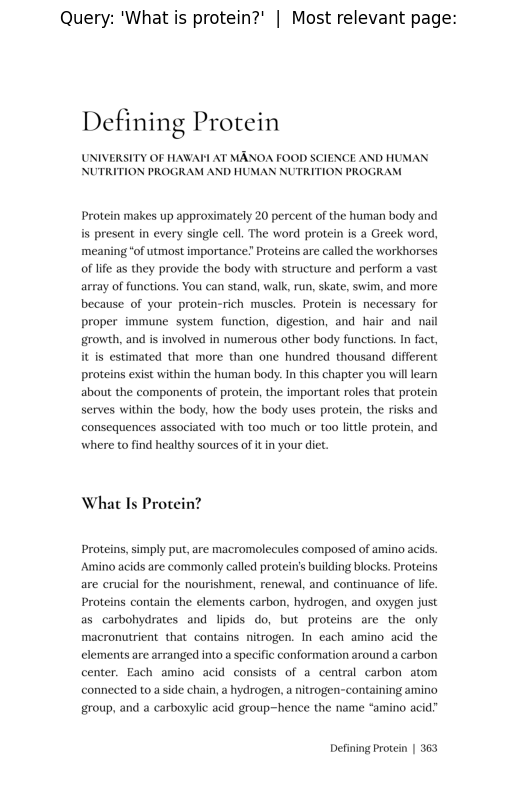

In [13]:
#Define the query (TODO: make the input prettier)
query = "What is protein?"

#Get indices of the most relevant contexts.
best_context_scores, best_context_indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

#Constructs the input prompt and gets the output
prompt = make_prompt(query=query, indices=best_context_indices, text_chunks_and_embedding_df=text_chunks_and_embedding_df)

#And finally get the output from the LLM (TODO: format this to make it prettier?)
output = get_output(prompt=prompt, llm_model=llm_model, llm_tokenizer=llm_tokenizer)
print(output)

#Display the page with the best context
show_correct_page(page_index=best_context_indices[0].item(), text_chunks_and_embedding_df=text_chunks_and_embedding_df)


##Clear VRAM (TODO: finish)

In [17]:
import gc
free_model_memory(llm_model)
gc.collect()

0

##Unformated code

In [ ]:
#Mount Google drive. I store all related files there
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Test for permanent storage
# import sys
# sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")
# !pip install -U virtualenv
# !virtualenv /content/drive/MyDrive/colab_env

In [ ]:
#Run only once

# !source /content/drive/MyDrive/colab_env/bin/activate && \
#   pip install -U PyMuPDF && \
#   pip install -U spacy && \
#   pip install -U scikit-learn && \
#   pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 && \
#   pip install -U sentence-transformers

!pip install -U PyMuPDF
!pip install -U spacy
!pip install -U scikit-learn
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U sentence-transformers
!pip install -U transformers==4.38.2
!pip install -U bitsandbytes
!pip install -U accelerate
#!pip install -U huggingface_hub[cli]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.3/757.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#Global imports

import pandas as pd
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import numpy as np
import torch
import fitz
from tqdm.auto import tqdm
import random
import ast
from time import perf_counter as timer
import matplotlib.pyplot as plt
import transformers

In [ ]:
#Global variables

#Assumes you have created a folder called RAG_project in your Google drive root directory
WEAK_GPU = True

PROJECT_LOCATION = '/content/drive/MyDrive/RAG_project'
PDF_LOCATION = PROJECT_LOCATION + '/human-nutrition-text.pdf'
EMBEDDINGS_DF_SAVE_PATH = '/content/drive/MyDrive/RAG_project/text_chunks_and_embeddings_df.csv'
LLM_MODEL_ID = "google/gemma-7b-it"

In [ ]:
#Helper function. Performs minor formatting on text. Specific to human-nutrition-text.pdf
def text_formatter(text: str) -> str:
  cleaned_text = text.replace("\n", " ").strip()
  return cleaned_text

#Open the pdf and start extracting information from it into a list[dict]
def open_and_read_pdf(pdf_path: str) -> list[dict]:
  doc = fitz.open(pdf_path)
  pages_and_texts = []
  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text=text)
    pages_and_texts.append({"page_number": page_number - 41, #Specific to the file, current one starts counting pages from page 42
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count_raw": len(text.split(". ")),
                            "page_token_count": len(text)/ 4,  #One token is roughly four characters
                            "text": text})
  return pages_and_texts


pages_and_text = open_and_read_pdf(PDF_LOCATION)
pages_and_text[99]

#Open the file


0it [00:00, ?it/s]

{'page_number': 58,
 'page_char_count': 584,
 'page_word_count': 88,
 'page_sentence_count_raw': 7,
 'page_token_count': 146.0,
 'text': 'benefits as a probiotic. Along with the beneficial components, natto  is very nutrient-dense containing carbohydrates, fats, protein, fiber,  vitamins and minerals.3 Other common foods we ferment in our diet  include miso, sauerkraut, kombucha, and tempeh.  Figure 2.1 Components of Organ Systems in the Human Body  \xa0 3.\xa0Sanjukta S, Rai AK. (2016). Production of bioactive  peptides during soy fermentation and their potential  health benefits. Trends in Food Science and Technology,  50, 1-10. http:/ /www.sciencedirect.com/science/ article/pii/S0924224415300571  58  |  Introduction'}

In [ ]:
# Just a random lookup for a single entry
random.sample(pages_and_text, k=1)

[{'page_number': 646,
  'page_char_count': 1762,
  'page_word_count': 360,
  'page_sentence_count_raw': 1,
  'page_token_count': 440.5,
  'text': 'Micronutrient Sources  Recommended  Intakes for  adults  Major functions  Deficiency  diseases and  symptoms  Groups a for defic Calcium  Yogurt,  cheese,  sardines,  milk,  orange  juice,  turnip  1,000 mg/day  Component of  mineralized bone,  provides  structure and  microarchitecture  Increased  risk of  osteoporosis  Postmen women,  who are  actosein or vegan Phosphorus  Salmon,  yogurt,  turkey,  chicken,  beef,  lentils  700 mg/day  Structural  component of  bones, cell  membrane, DNA  and RNA, and ATP  Bone loss,  weak bones  Older ad alcoholic Magnesium  Whole  grains and  legumes,  almonds,  cashews,  hazelnuts,  beets,  collards,  and kelp  420 mg/day  Component of  mineralized bone,  ATP synthesis and  utilization,  carbohydrate,  lipid,protein,  RNA, and DNA  synthesis  Tremor,  muscle  spasms, loss  of appetite,  nausea  Alcohol

In [ ]:
# Using pandas to display data

# import pandas as pd
# df = pd.DataFrame(pages_and_text)

# .sample gets a random entry
# df.sample()

# .head gets first entry
# df.head()

#.describe provides us with stats about the data frame   .round(2) rounds it out to the nearest decimal point
#df.describe().round(2)


In [ ]:
#Further text pre-processing
# Split text into smaller chunks. Maybe sentences?
# You can split sentences by splitting on ". "
# But here an actual library will be used. spaCy
nlp = English()

# Add a sentencizer pipeline. It basiccally turns text into sentences.
nlp.add_pipe("sentencizer")

# Sentencize the text
for entry in tqdm(pages_and_text):
  #Create a new field "sentences" which has a list of sentences n the text
  entry["sentences"] = list(nlp(entry["text"]).sents)

  #Convert to strings (the default type is a spaCy Span datatype)
  entry["sentences"] = [str(sentence) for sentence in entry["sentences"]] #Very little code ♥

  # Count the sentences
  entry["page_sentence_count_spacy"] = len(entry['sentences'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
# df = pd.DataFrame(pages_and_text)
# df.describe().round(2)

In [ ]:
# Chunk sentences together. For this one, let's try groups of 10.
# We can use a library, like Langchain TextSplitters, to do this
# But we will use pure python

chunk_size = 10

def split_list (input_list: list,
                slice_size: int) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range (0, len(input_list), slice_size)]



In [ ]:
# Use the above function of actual chunks
for entry in tqdm(pages_and_text):
  #New field for sentence chunks of 10
  entry["sentence_chunks"]= split_list(input_list=entry["sentences"],
                                       slice_size=chunk_size)
  #New field for the unmber of chunks
  entry['num_chunks'] = len(entry["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
# df = pd.DataFrame(pages_and_text)
# df.describe().round(2)

In [ ]:
#We might want to have chunks of 10 sentences as separate objects

pages_and_chunks = []

for entry in tqdm(pages_and_text):
  for sent_chunk in entry['sentence_chunks']:
    chunk_dict = {}
    chunk_dict['page_number'] = entry['page_number']
    # Now join lists of 10 sentences into paragraphs of 10 sentences
    joined_sentence_chunk= "".join(sent_chunk)
    joined_sentence_chunk = joined_sentence_chunk.replace("  ", " ").strip() #More pre-processing for this particular file
    joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) #Changes ".A" => ". A"
    chunk_dict["sentence_chunk"] = joined_sentence_chunk

    #Some stats
    chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
    chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
    chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 #Approximate, assuming 4 char = 1 token

    pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)


  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [ ]:

df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


In [ ]:
#Small chunks (chunk is a paragraph of 10 sentences) might not contain
# a lot of useful info. So, we disregard them.

min_chunk_length = 30 #tokens
#for row in df[df['chunk_token_count'] <= min_chunk_length].sample(5).iterrows(): ##TODO: understand df[df[]] thing
#  print(f'Chunk token count: {row[1]["chunk_token_count"]} ||| Text: {row[1]["sentence_chunk"]}')

pages_and_chunks_over_min_len = df[df["chunk_token_count"] > min_chunk_length].to_dict(orient="records")
random.sample(pages_and_chunks_over_min_len, k=1)

[{'page_number': 49,
  'sentence_chunk': 'Were there ten or one hundred participants?What did the participants actually do?Did the researcher(s) observe the results themselves or did they rely on self reports from program participants? 3. Who were the subjects of this study?Humans or animals?If human, are any traits/characteristics noted?You may realize you have more in common with certain program participants and can use that as a basis to gauge if the study applies to you. 4. Credible reports often disseminate new findings in the context of previous research.',
  'chunk_char_count': 525,
  'chunk_word_count': 82,
  'chunk_token_count': 131.25}]

In [ ]:
#EMBEDDING
#Now the fun part! Turn chunks into embeddings

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cuda") #Can be cpu or cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# for entry in tqdm(pages_and_chunks_over_min_len):
#     entry["embedding"] = embedding_model.encode(entry["sentence_chunk"])

#Do embeddings in batches
#Get all chunks into separate list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_len]

#Create embeddings
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=64 #VRAM dependant
                                               )

In [ ]:
#type(text_chunk_embeddings)

In [ ]:
#Save embeddings for later, so we don't have to reembed them again
#We might want to create another data frame here

# type(pages_and_chunks_over_min_len)
# # pages_and_chunks_over_min_len["embeddings"] = text_chunk_embeddings
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_len)

text_chunks_and_embeddings_df['embeddings'] = [list(row) for row in text_chunk_embeddings] ##Importnat: how to turn ndarray into a list I can add to pandas df
text_chunks_and_embeddings_df.to_csv(EMBEDDINGS_DF_SAVE_PATH, index=False)

**Note using csv is pretty good for storing small instances of this
In actuality I would probably want to use a vector database **

In [ ]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(EMBEDDINGS_DF_SAVE_PATH)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embeddings
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.06742426, 0.09022821, -0.0050954777, -0.031..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.05521561, 0.059213955, -0.016616706, -0.020..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.027980171, 0.03398143, -0.020642664, 0.0019..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.06825669, 0.03812748, -0.008468554, -0.0181..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.03302642, -0.008497655, 0.009571581, -0.004..."


In [ ]:
#Now comes even more fun
#We will have to do a semantic search based on query for our embeddings

device = "cuda" if torch.cuda.is_available else "cpu" #MIGHT BE OOM THING
#device = "cpu"

#import
text_chunks_and_embeddings_df = pd.read_csv(EMBEDDINGS_DF_SAVE_PATH)

#The embeding part got converted into strings when we convert to csv
#We need to change it back to a numpy.ndarray
text_chunks_and_embeddings_df['embeddings'] = text_chunks_and_embeddings_df['embeddings'].apply(lambda x: np.array(ast.literal_eval(x)))

#Convert textst and embeddings df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embeddings_df["embeddings"].tolist()), dtype=torch.float32).to(device)
embeddings.shape


torch.Size([1680, 768])

In [ ]:
#Only needed if not loaded already
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#Now we create a semantic search pipeline
# 1. Define a query string
# 2. Turn the query into an embedding
# 3. Perform a dot product or cosine similarity function between the text embeddings and the query embedding
# 4. Sort the results

#Defining query string
query = "Breastfeeding"
print(f"Query is: {query}")

#Embed it
q_embedding = embedding_model.encode(query, convert_to_tensor=True)

#Get similarity score with dot product (or use cosine similarity if the output is not normalised) ((WHYYYY??))
start_time = timer()
dot_scores = util.dot_score(a=q_embedding, b=embeddings)[0]
print(dot_scores)
end_time = timer()
print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# Get the top-k results (for now top 5)
top_results_dot_prod = torch.topk(dot_scores, k=5)
print(top_results_dot_prod)


Query is: Breastfeeding
tensor([0.2198, 0.1853, 0.1021,  ..., 0.1617, 0.0745, 0.1145], device='cuda:0')
[INFO] Time taken to get scores on 1680 embeddings: 0.07907 seconds.
torch.return_types.topk(
values=tensor([0.6251, 0.6230, 0.6116, 0.5988, 0.5875], device='cuda:0'),
indices=tensor([1178, 1144, 1160, 1158, 1179], device='cuda:0'))


Investigate ANN and Faiss https://www.activeloop.ai/resources/glossary/approximate-nearest-neighbors-ann/#:~:text=Approximate%20Nearest%20Neighbors%20(ANN)%20is,machine%20learning%2C%20and%20computer%20vision.

In [ ]:
#Above code in function
def retrieve_relevant_resources(query, embeddings):
  print(f"Query is: {query}")

  #Embed it
  q_embedding = embedding_model.encode(query, convert_to_tensor=True)

  #Get similarity score with dot product (or use cosine similarity if the output is not normalised) ((WHYYYY??))
  start_time = timer()
  dot_scores = util.dot_score(a=q_embedding, b=embeddings)[0]
  print(dot_scores)
  end_time = timer()
  print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

  # Get the top-k results (for now top 5)
  top_results_dot_prod = torch.topk(dot_scores, k=5)
  return top_results_dot_prod[0], top_results_dot_prod[1]

In [ ]:
top_results_dot_prod.indices

tensor([1178, 1144, 1160, 1158, 1179])

In [ ]:
#RERANKING
# We can potentially improve the results by reranking the top k results
# Reranking is basically taking the top k entries chosen via our similarity search,
#  then we feed them, along with the initial prompt to another AI model.
#  That AI model is specialised in reranking. It basically looks at the k entries
#  that are chosen via similarity search and potentially changes their order based
#  on it's own measure of similarity.

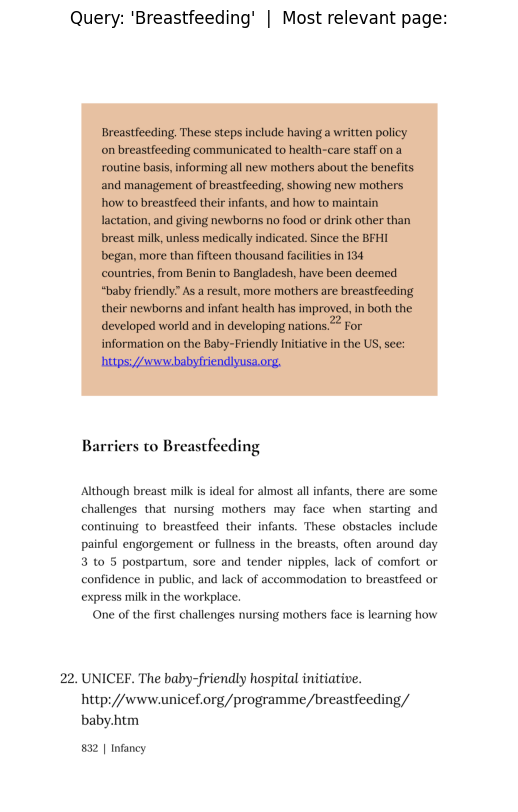

In [ ]:
#Simplified way to get the actaul page that has the most similarity to the entry

doc = fitz.open(PDF_LOCATION)
correct_page = pages_and_chunks[top_results_dot_prod.indices[0]]["page_number"]
page = doc.load_page(correct_page+41) ##Acount for the 41 unnumerated pages

#Another fitz fuction. Gets an image representation of the page
img = page.get_pixmap(dpi=300)

#Save the image (optional)
#img.save("output_filename.png")


#Convert pixmap toa numpy array so we can feed it to matplotlib
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

#Display the image using Matplotlib

plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}'  |  Most relevant page:")
plt.axis("off")
plt.show()

In [ ]:
#Diferent way to do similarity search
# Building vector search from scratch

def dot_product(vec1, vec2):
  return torch.dot(vec1, vec2);

def l2_norm(vec):
  return torch.sqrt(torch.sum(vec**2))

def cosine_similarity (vec1, vec2):

  vec_dot_product = dot_product(vec1,vec2)

  #Get Euclidean/ L2 norm
  norm_vector1 = l2_norm(vec1)
  norm_vector2 = l2_norm(vec2)

  return vec_dot_product / (norm_vector1 * norm_vector2)

print(cosine_similarity(q_embedding, embeddings[0])) #<--- Outputs a scalar tensor


tensor(0.2198, device='cuda:0')


In [ ]:
# TIME TO LOAD AN LLM !!!!
#First check VRAM (cool way in code)

gpu_mem = torch.cuda.get_device_properties(0).total_memory
gpu_mem_gb = round(gpu_mem / (2**30))
print(f"Memory available: {gpu_mem_gb}")

#Or you can use !nvidia-smi... LIKE A NERD

Memory available: 15


In [ ]:
# When loading a model there are a few parameters to consider
# 1) A quantization config (optional) - a config on what precision to load the model in (4/8/16/32 bit). There is a default,
#    we can try loading at lower precision for less memory ocupied. Loading at higher than default gives no benefits.
# 2) A model ID
# 3) Tokenizer (turns words into numerical tokens)
# 4)

In [ ]:
#There is a lot of tricks to make LLM run/load faster
#I.e. Using FlashAttention. Messes with the attection mechanism in LLMs.
# FlashAttention is only possible on certain GPUs
#Bellow line shows if such technique is available on your current gpu
from transformers.utils import is_flash_attn_2_available
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0]) >= 8:
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa" #Scaled dot product attention


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig

#1) Creating a quantization config with BitsAndBytes. In case I decide to run on shit GPU

#quant_config = BitsAndBytesConfig(load_in_8bit=True)
quant_config = BitsAndBytesConfig(load_in_4bit = True,
                                  bnb_4bit_compute_dtype=torch.float16)

#2) Pick a model (we did that in the global variables section wayy above)

#3) Tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = LLM_MODEL_ID)

# 4. istantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path = LLM_MODEL_ID,
                                                 torch_dtype = torch.float16,
                                                 quantization_config = quant_config if WEAK_GPU else None,
                                                 low_cpu_mem_usage=False, #If in low RAM enviroment, then true. Model first loads into RAM then VRAM.
                                                 #device_map="auto",
                                                 attn_implementation=attn_implementation)

if not WEAK_GPU:
  llm_model.to("cuda")

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
#GENERATING TEXT WITHA LOADED MODEL
#Some (or most) LLM models were trained using a specific input template
#This means, all data has been fed to them in a very specific manner
#We don't necesearrily have to follow the same template they have used for training, BUT
#it is HIGHLY advised if we want good results

#Bellow code is specific to gemma-7b-it model
messsage = "What is your favorite cartoon?"
chat = [{
    "role": "user",
    "content": messsage
}]
prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
print(prompt)
tokenized_prompt = tokenizer(prompt, return_tensors="pt").to("cuda") #TODO: investigate attention masks
print(tokenized_prompt)
outputs = llm_model.generate(**tokenized_prompt, #**takes only the keys
                             max_new_tokens=256)
print(outputs)

<bos><start_of_turn>user
What is your favorite cartoon?<end_of_turn>
<start_of_turn>model

{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    603,    861,   7827,
          16279, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[     2,      2,    106,   1645,    108,   1841,    603,    861,   7827,
          16279, 235336,    107,    108,    106,   2516,    108, 235285,   1144,
            780,  13920,    576,  31752,  22079,    689,  22733, 235269,   5852,
            590,    749,    780,    791,    573,   7924,    577,    791,    476,
           7827,  16279, 235265,      1]], device='cuda:0')


In [ ]:
#Decode output tokens to text
def decode_outputs(outputs):
  outputs_decoded = tokenizer.decode(outputs[0])
  return outputs_decoded

In [ ]:
scores, indices = retrieve_relevant_resources(embeddings=embeddings,
                                              query='How many times should you breastfeed a child for per day?')
scores, indices

Query is: How many times should you breastfeed a child for per day?
tensor([0.1202, 0.1057, 0.0681,  ..., 0.0640, 0.0317, 0.0561], device='cuda:0')
[INFO] Time taken to get scores on 1680 embeddings: 0.00123 seconds.


(tensor([0.5566, 0.5364, 0.5351, 0.4898, 0.4672], device='cuda:0'),
 tensor([1144, 1151, 1160, 1138, 1178], device='cuda:0'))

In [ ]:
#AUGMENTING INPUT WITH DATA
#Format input
def promt_formatter (query: str,
                    context_items: list[dict]) -> str:
  context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
  new_prompt = f"Based on the following contexts:\n {context}\n Please answer the following query: \n{query}"
  return new_prompt

#Retrieve a list of context items from our enbeddings search
def create_context_items (pages_and_chunks: list[dict],
                          indices: list[int]) -> list[dict]:
  context_items = [pages_and_chunks[index] for index in indices]
  return context_items

context_items = create_context_items(pages_and_chunks=pages_and_chunks,
                                     indices=indices.tolist())
prompt = promt_formatter(query = "How many times should you breastfeed a child for per day?",
                         context_items = context_items)
print(prompt)

Based on the following contexts:
 - child is 1 year old.7 See: https:/ /wicworks.fns.usda.gov/resources/ 50-state-summary-breastfeeding-laws Everyday Connection In the Pacific, the state of Hawai‘i and and the territory of Guam are mandated to provide several accommodations within the workplace for new mothers. All employers are to required to allow breastfeeding mothers adequate break time to pump or nurse in location other than a bathroom. To learn more about Hawai‘i’s laws visit http:/ /health.hawaii.gov/wic/files/2013/04/ WorkplaceBreastfeeding_02_2014.pdf and for Guam’s laws visit  http:/ /www.guamcourts.org/CompilerofLaws/GCA/ 10gca/10gc092A.pdf. Members of a community can also promote and support breastfeeding. New mothers can join peer counseling groups or turn to other women within their community who have previous experience with breastfeeding. In addition, community-based programs can provide education and support. The US Department of Agriculture’s Women, Infants, and Child

In [ ]:
# Feed augmented with context query to llm
chat = [{
    "role": "user",
    "content": prompt
}]
prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
tokenized_prompt = tokenizer(prompt, return_tensors="pt").to("cuda") #TODO: investigate attention masks
outputs = llm_model.generate(**tokenized_prompt, #**takes only the keys
                             temperature=0.7, #from 0 to 1. Lower - deterministic, higher - creative outputs
                             max_new_tokens=256)
print(outputs)

tensor([[     2,      2,    106,  ...,    978, 235265,      1]],
       device='cuda:0')


In [ ]:
print(decode_outputs(outputs))

<bos><bos><start_of_turn>user
Based on the following contexts:
 - child is 1 year old.7 See: https:/ /wicworks.fns.usda.gov/resources/ 50-state-summary-breastfeeding-laws Everyday Connection In the Pacific, the state of Hawai‘i and and the territory of Guam are mandated to provide several accommodations within the workplace for new mothers. All employers are to required to allow breastfeeding mothers adequate break time to pump or nurse in location other than a bathroom. To learn more about Hawai‘i’s laws visit http:/ /health.hawaii.gov/wic/files/2013/04/ WorkplaceBreastfeeding_02_2014.pdf and for Guam’s laws visit  http:/ /www.guamcourts.org/CompilerofLaws/GCA/ 10gca/10gc092A.pdf. Members of a community can also promote and support breastfeeding. New mothers can join peer counseling groups or turn to other women within their community who have previous experience with breastfeeding. In addition, community-based programs can provide education and support. The US Department of Agricultu

In [ ]:
#Calculate number of pramaters in LLM
def get_model_num_params(model: torch.nn.Module):
  return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

8537680896

In [ ]:
# Calculate how much memory it takes up
def get_model_mem_size(model: torch.nn.Module):
  #Get model parameters and buffer sizes
  mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
  mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
  total_mem_gb = round((mem_params + mem_buffers)/(1024**3), 2)
  return print(f'Memory taken up in GB: {total_mem_gb}')

get_model_mem_size(llm_model)

Memory taken up in GB: 8.75


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [ ]:
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
import gc
del llm_model
gc.collect()

8492

In [ ]:
torch.cuda.memory_allocated()

18791566336

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!nvidia-smi

Tue Apr 16 18:16:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              39W / 300W |  16120MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Extensions

Investigate better loading of LLM https://huggingface.co/docs/accelerate/v0.25.0/en/concept_guides/big_model_inference

May want to improve text extraction with something like Marker - https://github.com/VikParuchuri/marker

Guide to more advanced PDF extraction - https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517

See the following prompt engineering resources for more prompting techniques - promptinguide.ai, Brex's Prompt Engineering Guide


What happens when a query comes through that there isn't any context in the textbook on?

Try another embedding model (e.g. Mixed Bread AI large, mixedbread-ai/mxbai-embed-large-v1, see: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

Try another LLM... (e.g. Mistral-Instruct)

Try different prompts (e.g. see prompting techniques online)

Our example only focuses on text from a PDF, however, we could extend it to include figures and images
Evaluate the answers -> could use another LLM to rate our answers (e.g. use GPT-4 to make)

Vector database/index for larger setup (e.g. 100,000+ chunks)

Libraries/frameworks such as LangChain / LlamaIndex can help do many of the steps for you - so it's worth looking into those next, wanted to recreate a workflow with lower-level tools to show the principles
Optimizations for speed

See Hugging Face docs for recommended speed ups on GPU - https://huggingface.co/docs/transformers/perf_infer_gpu_one

Optimum NVIDIA - https://huggingface.co/blog/optimum-nvidia, GitHub: https://github.com/huggingface/optimum-nvidia

See NVIDIA TensorRT-LLM - https://github.com/NVIDIA/TensorRT-LLM

See GPT-Fast for PyTorch-based optimizations - https://github.com/pytorch-labs/gpt-fast

Flash attention 2 (requires Ampere GPUs or newer) - https://github.com/Dao-AILab/flash-attention

Stream text output so it looks prettier (e.g. each token appears as it gets output from the model)

Turn the workflow into an app, see Gradio type chatbots for this - https://www.gradio.app/guides/creating-a-chatbot-fast, see local example: https://www.gradio.app/guides/creating-a-chatbot-fast#example-using-a-local-open-source-llm-with-hugging-face


